In [1]:
import numpy as np
import pandas as pd
import glob
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
from IPython.display import clear_output

# Matplotlib config
#============================
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"
#============================





# Local imports
import WireDAQ.PandasPlus # Make sure this import is after pandas

import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.Spark as spark
# import WireDAQ.Efficiency as eff

import sys
sys.path.append('./Executables/py_wireDAQ/fillingstudies/')
from tools_box.analysis import bb_tool_box as bbsc 

clear_output(wait=False)

# Creating NXCALS variable containers
#============================================
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
LHC       = nx.NXCALSLHC()
buckets   = np.arange(3564)
#============================================


---
# Loading data locally (NOT saved)
---

In [2]:
# FILL NUMBER
# FILL = 8348 #MD
FILL = 8773

# Variables to be used
#============================================
LHC_vars   = LHC._getVarList(subset=[   'bb_Luminosity',
                                        'Luminosity',
                                        'Xing',
                                        'Fill',
                                        'Bmode',
                                        'betastar'])
beams_vars = sum([beam._getVarList(subset=[ 'bb_Intensity',
                                            'Intensity',
                                            'Nb',
                                            'dBLM_Amp']) for beam in beams],[])


wires_vars = sum([wire._getVarList(subset=[ 'I',
                                            'V']) for wire in wires['B1']+wires['B2']],[])
all_vars = sorted(LHC_vars+beams_vars+wires_vars)
#============================================


# Loading the data
#============================================
spark_session = spark.SparkSession()
database      = spark_session.query(fill=FILL,variables = all_vars)
#============================================

# Reformating database
#============================================
database = database.sort_index()
database.index.name = 'unix'
database.insert(0,'Timestamp',database.index)
database.insert(1,'Time',1e-9*(database.index - database.index[0]))
database['Timestamp'] = database['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC').tz_convert(spark_session.TZONE))
#============================================


kinit: Pre-authentication failed: Key table file '/home/phbelang/phbelang.keytab' not found while getting initial credentials


Trying to determine YARN usage to make Python work correctly (conf/spark-env.sh)...
Not using YARN
Using virtual venv /home/phbelang/abp/WireDAQ/Executables/py_wireDAQ
PYSPARK_PYTHON == /home/phbelang/abp/WireDAQ/Executables/py_wireDAQ/bin/python
PYSPARK_DRIVER_PYTHON == /home/phbelang/abp/WireDAQ/Executables/py_wireDAQ/bin/python
PYSPARK_DRIVER_PYTHON_OPTS == 


23/05/17 20:37:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/17 20:37:27 WARN DomainSocketFactory: The short-circuit local reads feature cannot be used because libhadoop cannot be loaded.
23/05/17 20:37:28 WARN URLConfigurationSource: No URLs will be polled as dynamic configuration sources.
23/05/17 20:37:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
23/05/17 20:37:34 WARN HdfsDatasetCreator: Nothing to be queried as the relevant paths [/project/nxcals/nxcals_pro/data/2/14848/176076/2023/5/15/*.parquet] do not exists
23/05/17 20:38:31 WARN ClientCnxn: An exception was thrown while closing send thread for session 0x3037eba7787991d.
EndOfStreamException: Unable to read additional data from server sessionid 0x3037eba7787991d, likely server has closed socket
	at org.apache.zookeeper.ClientCnxnSocketNIO.doIO(ClientCnxnSocketNIO.java:77)
	at org.a

---
# Plotting LHC conditions
---

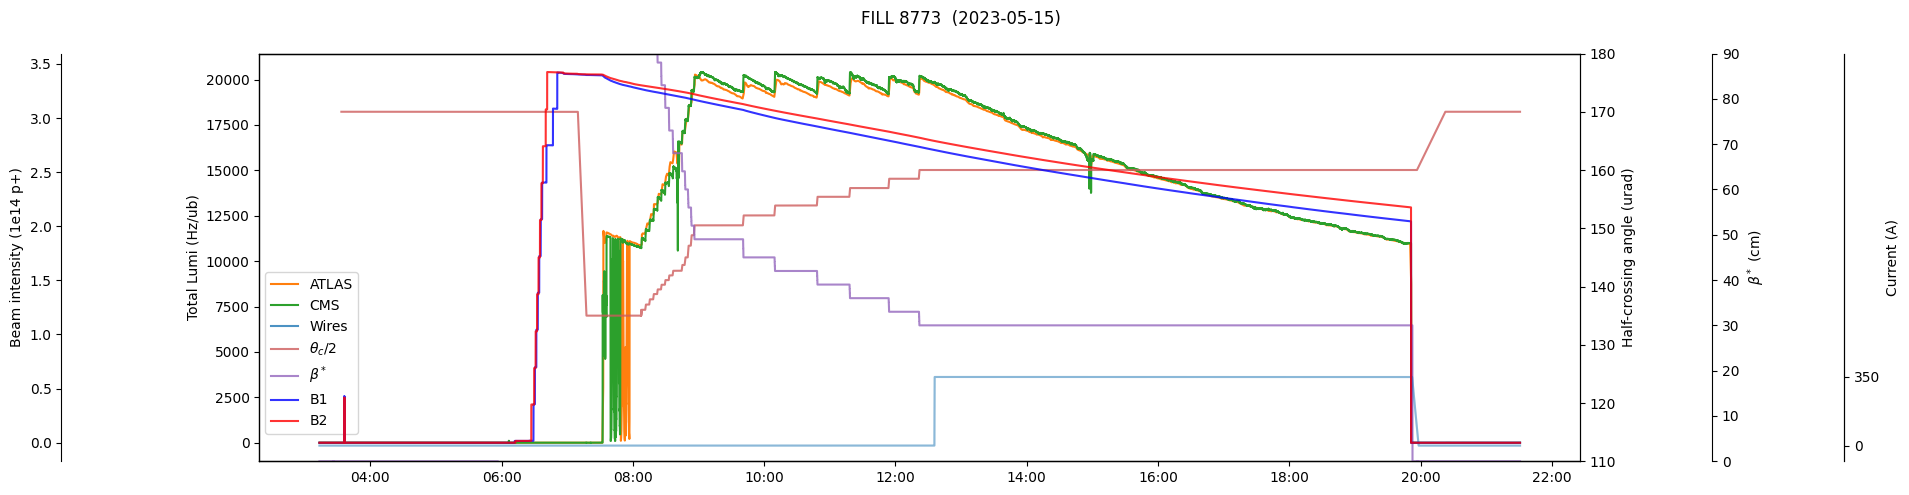

In [3]:
# Plotting

fig  = plt.figure(figsize=(20,5))
plt.suptitle(f'FILL {FILL:d}  ({database["Timestamp"].iloc[0].strftime("%Y-%m-%d")})')

for loc,color in zip(['ATLAS','CMS'],['C1','C2']):
    data = database.set_index('Timestamp')[LHC['bb_Luminosity'][loc]].dropna()

    plt.plot(data.index,data.apply(lambda line: np.sum(line)),color=color,label=loc)
# plt.ylim([-100,2200])


plt.plot([np.nan],[np.nan],color='C0',alpha=0.8,label='Wires')
plt.plot([np.nan],[np.nan],color='indianred',alpha=0.8,label=r'$\theta_c/2$')
plt.plot([np.nan],[np.nan],color='C4',alpha=0.8,label=r'$\beta^*$')

plt.plot([np.nan],[np.nan],color='b',alpha=0.8,label='B1')
plt.plot([np.nan],[np.nan],color='r',alpha=0.8,label='B2')

plt.legend(loc='lower left',bbox_to_anchor=(-0.001,0.05))#, bbox_transform=fig.transFigure)
plt.ylabel('Total Lumi (Hz/ub)');
# plt.xlim([MD_start,MD_stop])
# plt.suptitle(MD_title)

# Plot also wire current and crossing angle
ax = plt.gca()
ax_xing = ax.twinx()
ax_betas = ax.twinx()
ax_betas.spines.right.set_position(("axes", 1.1))
ax_wire = ax.twinx()
ax_wire.spines.right.set_position(("axes", 1.2))

ax_intensity = ax.twinx()
ax_intensity.spines.right.set_position(("axes", 1.2))
ax_intensity.yaxis.set_ticks_position("left")
ax_intensity.yaxis.set_label_position("left")
ax_intensity.spines["left"].set_position(("axes", -0.15))
# ax_intensity.set_frame_on(True)
# ax_intensity.patch.set_visible(False)


plt.sca(ax_wire)
for wire in wires['B2']:
    database.nxPlot('Timestamp',wire.I,color='C0',alpha=0.3)
plt.ylabel('Current (A)')
# plt.ylim([-1500,380])
plt.ylim([-80,2000])
plt.yticks([0,350])

plt.sca(ax_xing)
database.nxPlot('Timestamp',LHC.Xing['IP5'],color='indianred',alpha=0.8)
plt.ylabel('Half-crossing angle (urad)')
plt.ylim([110,180])


plt.sca(ax_betas)
data = database.set_index('Timestamp')[LHC.betastar['IP5']].dropna()
data[(data>90)|(data<0)]=np.nan
plt.plot(data.index,data,color='C4',alpha=0.8)
plt.ylabel(r'$\beta^*$ (cm)')
plt.ylim([0,90])



plt.sca(ax_intensity)
for beam,color in zip(beams,['b','r']):
    data = database.set_index('Timestamp')[beam.Intensity].dropna()
    plt.plot(data.index,data/1e14,color=color,alpha=0.8)
# database.nxPlot('Timestamp',LHC.Xing['IP5'],color='indianred',alpha=0.8)
plt.ylabel('Beam intensity (1e14 p+)')



plt.tight_layout()

---
# Filling pattern
---

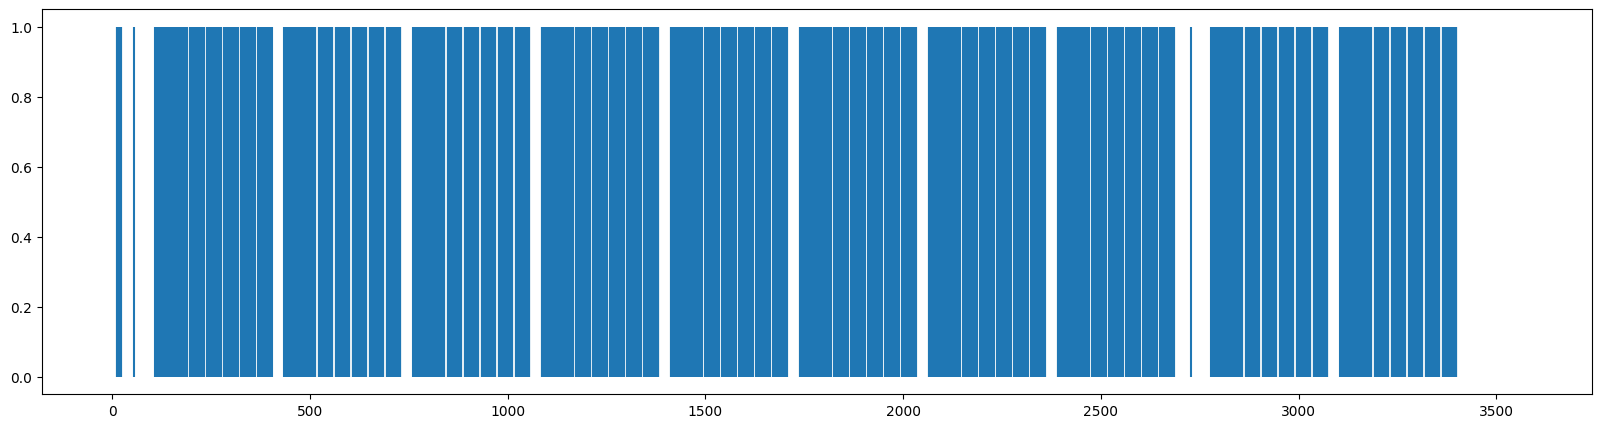

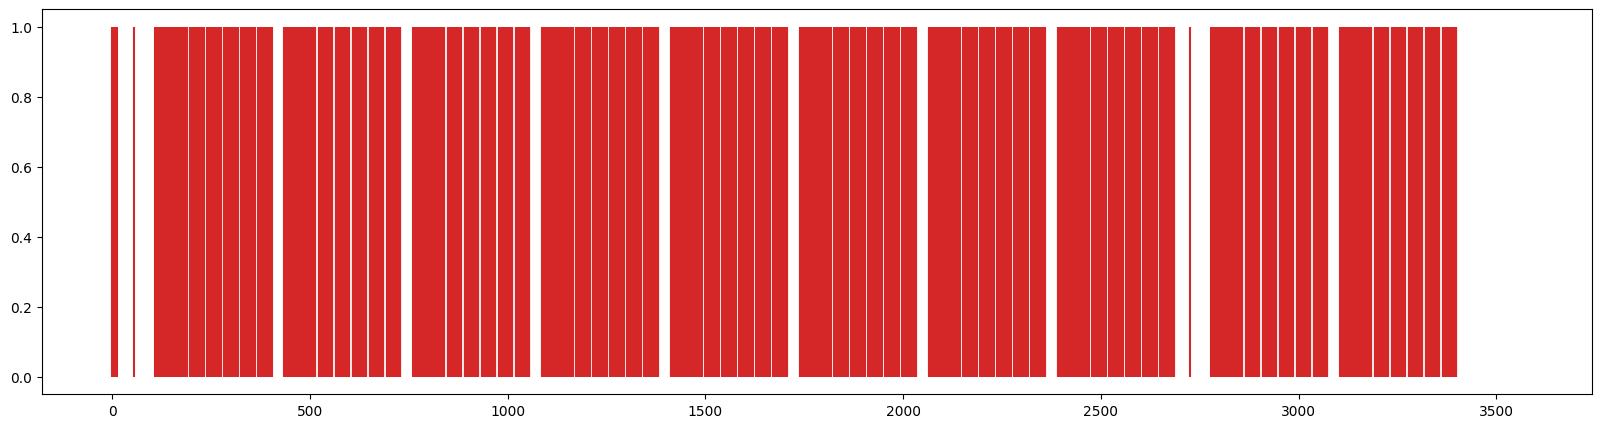

In [4]:
# Extracting patter
#==================================================
filled_buckets = {}
for beam in beams:
    
    # Only looking at after max of intensity
    bb_I    = database[beam['bb_Intensity']].dropna()
    max_loc = bb_I.apply(lambda line: np.sum(line)).argmax()
    bb_I    = bb_I.iloc[max_loc:]


    # Taking bb intensity just after max signal and then 1/4 of the way
    probe1 = bb_I.iloc[20-10:20+10].mean(axis=0)
    probe2 = bb_I.iloc[len(bb_I)//4-10:len(bb_I)//4+10].mean(axis=0)


    assert(np.all((probe1!=0) == (probe2!=0))), 'Error on the filling scheme'

    filled_buckets[beam.name] = (probe1!=0).astype(int)


for beam,color in zip(beams,['C0','C3']):
    plt.figure(figsize=(20,5))
    plt.stem(filled_buckets[beam.name],basefmt='none',linefmt=color,markerfmt='none')


bb_df_b1,bb_df_b2 = bbsc.bbschedule(filled_buckets['B1'],filled_buckets['B2'],numberOfLRToConsider = 21, 
                                                                                    Dict_Detectors = {  'ATLAS' : int(0/8 * (3564 * 2)),
                                                                                                        'ALICE' : int(1/8 * (3564 * 2)),
                                                                                                        'CMS'   : int(4/8 * (3564 * 2)),
                                                                                                        'LHCB'  : int(7/8 * (3564 * 2)) - 3 })



# patt = eff.getFillingPattern(patterns['B1'],patterns['B2'])


In [10]:

bb_df_b1
 

,# of LR in ATLAS,HO partner in ATLAS,BB partners in ATLAS,Positions in ATLAS,# of LR in ALICE,HO partner in ALICE,BB partners in ALICE,Positions in ALICE,# of LR in CMS,HO partner in CMS,BB partners in CMS,Positions in CMS,# of LR in LHCB,HO partner in LHCB,BB partners in LHCB,Positions in LHCB
12,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",35.0,903.0,"[882.0, 883.0, 891.0, 892.0, 893.0, 894.0, 895...","[-21.0, -20.0, -12.0, -11.0, -10.0, -9.0, -8.0...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",24.0,2682.0,"[2661.0, 2662.0, 2663.0, 2664.0, 2665.0, 2666....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
13,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",35.0,904.0,"[883.0, 891.0, 892.0, 893.0, 894.0, 895.0, 896...","[-21.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",23.0,2683.0,"[2662.0, 2663.0, 2664.0, 2665.0, 2666.0, 2667....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
14,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",35.0,905.0,"[891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",22.0,2684.0,"[2663.0, 2664.0, 2665.0, 2666.0, 2667.0, 2668....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
15,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",35.0,906.0,"[891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",21.0,2685.0,"[2664.0, 2665.0, 2666.0, 2667.0, 2668.0, 2669....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
16,12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",35.0,907.0,"[891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",12.0,NaN,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",21.0,NaN,"[2665.0, 2666.0, 2667.0, 2668.0, 2669.0, 2670....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,25.0,3395.0,"[3374.0, 3375.0, 3376.0, 3377.0, 3378.0, 3379....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",28.0,722.0,"[701.0, 702.0, 703.0, 704.0, 705.0, 706.0, 707...","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",25.0,3395.0,"[3374.0, 3375.0, 3376.0, 3377.0, 3378.0, 3379....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2501.0,"[2480.0, 2481.0, 2482.0, 2483.0, 2484.0, 2485....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
3396,24.0,3396.0,"[3375.0, 3376.0, 3377.0, 3378.0, 3379.0, 3380....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",27.0,723.0,"[702.0, 703.0, 704.0, 705.0, 706.0, 707.0, 708...","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",24.0,3396.0,"[3375.0, 3376.0, 3377.0, 3378.0, 3379.0, 3380....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2502.0,"[2481.0, 2482.0, 2483.0, 2484.0, 2485.0, 2486....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15..."
3397,23.0,3397.0,"[3376.0, 3377.0, 3378.0, 3379.0, 3380.0, 3381....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",26.0,724.0,"[703.0, 704.0, 705.0, 706.0, 707.0, 708.0, 709...","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",23.0,3397.0,"[3376.0, 3377.0, 3378.0, 3379.0, 3380.0, 3381....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2503.0,"[2482.0, 2483.0, 2484.0, 2485.0, 2486

In [ ]:
%3564

In [43]:
np.mod((0*len(buckets)/8 )*2,3564)

0.0

In [45]:
np.mod((1*len(buckets)/8 )*2,3564)

891.0

In [ ]:
np.mod((4*len(buckets)/8 )*2,3564)

In [42]:
np.mod((7*len(buckets)/8 - 1.5)*2,3564)

2670.0

In [48]:
np.mod(6234,3564)

2670

In [47]:
{  'ATLAS' : 0 * (3564/8 * 2),
                                                                                                        'ALICE' : 1 * (3564/8 * 2),
                                                                                                        'CMS'   : 4 * (3564/8 * 2),
                                                                                                        'LHCB'  : 7 * (3564/8 * 2) - 3 }

{'ATLAS': 0.0, 'ALICE': 891.0, 'CMS': 3564.0, 'LHCB': 6234.0}

In [49]:
{  'ATLAS' : 0/8 * (3564 * 2),
                                                                                                        'ALICE' : 1/8 * (3564 * 2),
                                                                                                        'CMS'   : 4/8 * (3564 * 2),
                                                                                                        'LHCB'  : 7/8 * (3564 * 2) - 3 }

{'ATLAS': 0.0, 'ALICE': 891.0, 'CMS': 3564.0, 'LHCB': 6234.0}

In [51]:

bb_df_b1

,# of LR in ATLAS,HO partner in ATLAS,BB partners in ATLAS,Positions in ATLAS,# of LR in ALICE,HO partner in ALICE,BB partners in ALICE,Positions in ALICE,# of LR in CMS,HO partner in CMS,BB partners in CMS,Positions in CMS,# of LR in LHCB,HO partner in LHCB,BB partners in LHCB,Positions in LHCB
0,0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[]
1,0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[]
2,0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[]
3,0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[]
4,0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[],0.0,NaN,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,25.0,2619.0,"[2598.0, 2599.0, 2600.0, 2601.0, 2602.0, 2603....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[],25.0,2619.0,"[2598.0, 2599.0, 2600.0, 2601.0, 2602.0, 2603....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[]
2620,24.0,2620.0,"[2599.0, 2600.0, 2601.0, 2602.0, 2603.0, 2604....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[],24.0,2620.0,"[2599.0, 2600.0, 2601.0, 2602.0, 2603.0, 2604....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[]
2621,23.0,2621.0,"[2600.0, 2601.0, 2602.0, 2603.0, 2604.0, 2605....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[],23.0,2621.0,"[2600.0, 2601.0, 2602.0, 2603.0, 2604.0, 2605....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[]
2622,22.0,2622.0,"[2601.0, 2602.0, 2603.0, 2604.0, 2605.0, 2606....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[],22.0,2622.0,"[2601.0, 2602.0, 2603.0, 2604.0, 2605.0, 2606....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",0.0,NaN,[],[]


In [87]:
bb_df_b1,bb_df_b2 = bbsc.bbschedule(filled_buckets['B1'],filled_buckets['B2'],numberOfLRToConsider = 21)

,# of LR in ATLAS,HO partner in ATLAS,BB partners in ATLAS,Positions in ATLAS,# of LR in ALICE,HO partner in ALICE,BB partners in ALICE,Positions in ALICE,# of LR in CMS,HO partner in CMS,BB partners in CMS,Positions in CMS,# of LR in LHCB,HO partner in LHCB,BB partners in LHCB,Positions in LHCB
0,10.0,NaN,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....",33.0,2673.0,"[2652.0, 2653.0, 2654.0, 2655.0, 2656.0, 2657....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",28.0,1782.0,"[1763.0, 1764.0, 1765.0, 1766.0, 1767.0, 1768....","[-19.0, -18.0, -17.0, -16.0, -15.0, -14.0, -13...",35.0,894.0,"[873.0, 874.0, 875.0, 876.0, 877.0, 878.0, 879...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
1,11.0,NaN,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....",32.0,2674.0,"[2653.0, 2654.0, 2655.0, 2656.0, 2657.0, 2658....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",30.0,NaN,"[1763.0, 1764.0, 1765.0, 1766.0, 1767.0, 1768....","[-20.0, -19.0, -18.0, -17.0, -16.0, -15.0, -14...",35.0,895.0,"[874.0, 875.0, 876.0, 877.0, 878.0, 879.0, 880...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
2,12.0,NaN,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17....",31.0,2675.0,"[2654.0, 2655.0, 2656.0, 2657.0, 2658.0, 2659....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",31.0,NaN,"[1763.0, 1764.0, 1765.0, 1766.0, 1767.0, 1768....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,896.0,"[875.0, 876.0, 877.0, 878.0, 879.0, 880.0, 881...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
3,12.0,NaN,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0...",30.0,2676.0,"[2655.0, 2656.0, 2657.0, 2658.0, 2659.0, 2660....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",31.0,NaN,"[1764.0, 1765.0, 1766.0, 1767.0, 1768.0, 1769....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,897.0,"[876.0, 877.0, 878.0, 879.0, 880.0, 881.0, 882...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
4,12.0,NaN,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0,...",29.0,2677.0,"[2656.0, 2657.0, 2658.0, 2659.0, 2660.0, 2661....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",30.0,NaN,"[1765.0, 1766.0, 1767.0, 1768.0, 1769.0, 1770....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -11...",35.0,898.0,"[877.0, 878.0, 879.0, 880.0, 881.0, 882.0, 883...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,25.0,3395.0,"[3374.0, 3375.0, 3376.0, 3377.0, 3378.0, 3379....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2504.0,"[2483.0, 2484.0, 2485.0, 2486.0, 2487.0, 2488....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",35.0,1613.0,"[1592.0, 1593.0, 1594.0, 1595.0, 1596.0, 1597....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",25.0,725.0,"[704.0, 705.0, 706.0, 707.0, 708.0, 709.0, 710...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
3396,24.0,3396.0,"[3375.0, 3376.0, 3377.0, 3378.0, 3379.0, 3380....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2505.0,"[2484.0, 2485.0, 2486.0, 2487.0, 2488.0, 2489....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",35.0,1614.0,"[1593.0, 1594.0, 1595.0, 1596.0, 1597.0, 1598....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",24.0,726.0,"[705.0, 706.0, 707.0, 708.0, 709.0, 710.0, 711...","[-1797.0, -1796.0, -1795.0, -1794.0, -1793.0, ..."
3397,23.0,3397.0,"[3376.0, 3377.0, 3378.0, 3379.0, 3380.0, 3381....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",35.0,2506.0,"[2485.0, 2486.0, 2487.0, 2488.0, 2489.0, 2490....","[1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766....",35.0,1615.0,"[1594.0, 1595.0, 1596.0, 1597.0, 1598.0, 1599....","[-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15...",23.0,727.0,"[706.0, 707.0, 708.0, 709.0, 710.0, 

In [44]:
bb_I    = database[beams[0]['bb_Intensity']].dropna()
max_loc = bb_I.apply(lambda line: np.sum(line)).argmax()

In [50]:
    # Only looking at after max of intensity
    bb_I    = database[beams[0]['bb_Intensity']].dropna()
    max_loc = bb_I.apply(lambda line: np.sum(line)).argmax()
    bb_I    = bb_I.iloc[max_loc:]


    # Taking bb intensity just after max signal and then 1/4 of the way
    probe1 = bb_I.iloc[20-10:20+10].mean(axis=0)
    probe2 = bb_I.iloc[len(bb_I)//4-10:len(bb_I)//4+10].mean(axis=0)


In [52]:
(probe1!=0)

array([False, False, False, ..., False, False, False])

True

In [51]:
probe1

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

3564

---
# Computing Efficiency
---

unix
1684123589491686000        5231.0
1684123590591684000        5231.0
1684123591691681000        5231.0
1684123592791678000        5231.0
1684123593891678000        5231.0
                          ...    
1684173070691684000    41167294.0
1684173071791680000    41167294.0
1684173072891674000    41167294.0
1684173073991670000    41167294.0
1684173075091755000    41167294.0
Name: LHC.BQM.B2:FILLED_BUCKETS, Length: 44866, dtype: float64

In [19]:
len(database[beams[1].Filled_b].dropna()//2)

59858

29929

In [24]:
database[beams[1].Filled_b].dropna().values[len(database[beams[1].Filled_b].dropna().values)//2]

array([ 1, 11, 21, ...,  0,  0,  0], dtype=int32)

In [6]:
database[beams[1].Filled_b].dropna()

KeyboardInterrupt: 